# inforet 2

In [ ]:
# no time to lose:
!wget https://gerdes.fr/saclay/inforet/our_msmarco.zip
!unzip our_msmarco.zip
# this will be big: 1.2gb!
# you will get three files 

## ↓ go down to the section "reading in our smaller files"


In [ ]:
# this turns on the autotimer, so that every cell has a timing information below
try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime
# stop using:
# %unload_ext autotime
!pip install sklearn

In [1]:
!pip install scikit-learn
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import Counter
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import CountVectorizer
import dask.dataframe as dd

## our dataset

- "TREC stands for the Text Retrieval Conference. Started in 1992 it is a series of workshops that focus on supporting research within the information retrieval community. It provides the infrastructure necessary for large-scale evaluation of text retrieval methodologies. Every year these workshops are organized, which are centered around a set of tracks. These tracks encourage new researches in the area of information retrieval."
- TREC 2019 Deep Learning Track https://microsoft.github.io/msmarco/TREC-Deep-Learning-2019
- data from MS-Marco https://microsoft.github.io/msmarco/
- The dataset contains  367k queries and a corpus of 3.2 million documents. 
___
- if you want to reproduce my selection or get a bigger set, uncomment and execute


In [ ]:
#!wget https://msmarco.blob.core.windows.net/msmarcoranking/msmarco-docs.tsv.gz
#!wget https://msmarco.blob.core.windows.net/msmarcoranking/msmarco-doctrain-queries.tsv.gz
#!wget https://msmarco.blob.core.windows.net/msmarcoranking/msmarco-doctrain-top100.gz
	
#!gzip -d msmarco-docs.tsv.gz
#!gzip -d msmarco-doctrain-queries.tsv.gz
#!gzip -d msmarco-doctrain-top100.gz


## skip to the section "reading in our smaller files"

come back here if you want to understand how to reduce the dataset or you want to build your own dataset

- we have three datasets:
    
    1. the queries: msmarco-doctrain-queries.tsv
    2. the gold: msmarco-doctrain-top100.tsv is a table containing query_id, doc_id and rank
    3. the actual documents: msmarco-docs.tsv 21GB of text! doc_id, url, title, text

In [ ]:
all_queries=pd.read_table('msmarco-doctrain-queries.tsv',header=None)
all_queries.columns=['qid','query']
print('Shape=>',all_queries.shape)
all_queries.head()

#### reducing the dataset
- here we take 1000 queries. 
- if this is too big for your computer, use this code to build smaller version, starting with the already reduced 1000 query set that we've downloaded before


In [ ]:
our_queries=all_queries.sample(n=1000,random_state=42).reset_index(drop=True)
print('Shape=>',our_queries.shape)
our_queries.head()

In [ ]:
our_queries.to_csv('our.msmarco.queries.tsv',sep='\t')

#### the gold file
- 36m lines!

In [ ]:
gold_top100=pd.read_table('msmarco-doctrain-top100',delimiter=' ',header=None)
gold_top100.columns=['qid','Q0','docid','rank','score','runstring']
print('Shape=>',gold_top100.shape)
display(gold_top100.head())
# Reducing train_top100 for training
our_gold_top100=train_top100[gold_top100['qid'].isin(our_queries['qid'].unique())].reset_index(drop=True)
print('Shape=>',our_gold_top100.shape)
our_gold_top100.head()

In [ ]:
our_gold_top100.to_csv('our.msmarco.gold.tsv',sep='\t')

#### the data file

- it's so big that it's smarter to use dask: https://docs.dask.org/en/stable/

In [ ]:
df=dd.read_table('msmarco-docs.tsv',blocksize=100e6,header=None) #  partitions of 100MB
df.columns=['docid','url','title','body']
df.head()

In [ ]:
# can't get the number of rows quickly :s
# very slow:
# len(df.index)

# faster:
!wc -l msmarco-docs.tsv

- big dataset with 3m rows!
- we want the top 100 for our queries
- this takes some time!

In [ ]:
def create_corpus(result):
  unique_docid=result['docid'].unique()
  condition=df['docid'].isin(unique_docid)
  corpus=df[condition].reset_index(drop=True)
  corpus=corpus.drop(columns='url')
  print('Number of Rows=>',len(corpus))
  return corpus

our_docs=create_corpus(our_gold_top100)
our_docs.head()

In [ ]:
our_docs.to_csv('our.msmarco.docs.tsv',sep='\t', single_file=True)

- this is still a big file: 92k documents

# reading in our smaller files
here we use the

- !wget https://gerdes.fr/saclay/informationRetrieval/our_msmarco.zip
- !unzip our_msmarco.zip

In [2]:
queries = pd.read_csv('our.msmarco.queries.tsv',sep='\t',usecols=[1,2])
queries

,qid,query
0,687888,what is a jpe
1,480210,price for asphalt driveway
2,591004,what causes pressure skin bruising
3,260536,how long drive from flagstaff to grand canyon
4,39422,average number of bowel movements per day for ...
...,...,...
995,89597,cell voltage mv meaning
996,1167043,what an ip address
997,737304,what is daily max citizens atm
998,156934,do i need a florida commercial driver license


In [3]:
gold = pd.read_csv('our.msmarco.gold.tsv',sep='\t',usecols=[1,3,4,5])
gold

,qid,docid,rank,score
0,310290,D579750,1,-5.11498
1,310290,D579754,2,-5.57703
2,310290,D2380815,3,-5.84852
3,310290,D822566,4,-5.95002
4,310290,D2249695,5,-6.08326
...,...,...,...,...
99995,257942,D253854,96,-6.32693
99996,257942,D3056621,97,-6.32837
99997,257942,D1323491,98,-6.32871
99998,257942,D2722485,99,-6.33100


In [4]:
docs = pd.read_csv('our.msmarco.docs.tsv',sep='\t',usecols=[1,2,3])
docs

,docid,title,body
0,D2981241,What do you call a group of lions?,Lions Vocabulary of the English Language Word ...
1,D687756,.,"The A Priori Argument ( also, Rationalization;..."
2,D913099,Everything You Need To Learn How To Cook Veget...,Home > How To Cook Vegetables Everything You N...
3,D328017,"What is the difference between latitude, longi...",Longitude Latitude Geographic Coordinate Syste...
4,D1636347,When was the pulley invented?,Answers.com ® Wiki Answers ® Categories Techno...
...,...,...,...
92560,D3379210,Top 39 Doctor insights on: Can An Iud Cause Ha...,Top 39 Doctor insights on: Can An Iud Cause Ha...
92561,D3068739,How to get back your DirecTV cancellation fees,How to get back your Direc TV cancellation fee...
92562,D1590402,Certification FAQs,Fingerprinting 1. Where can I get fingerprinte...
92563,D2175490,Greenhouse gas emissions by Canadian economic ...,"Access PDF (682 KB)In 2015, Canada's total gre..."


In [5]:
training_queries=queries.iloc[:500]
print('Shape=>',training_queries.shape)
display(training_queries.head())
testing_queries=queries.iloc[500:]
print('Shape=>',testing_queries.shape)
testing_queries.head()

Shape=> (500, 2)


,qid,query
0,687888,what is a jpe
1,480210,price for asphalt driveway
2,591004,what causes pressure skin bruising
3,260536,how long drive from flagstaff to grand canyon
4,39422,average number of bowel movements per day for ...


Shape=> (500, 2)


,qid,query
500,116364,decree verb definition
501,638813,what does hemiballistic mean
502,401631,is advil considered aspirin?
503,1050265,who sang the song midnight train to georgia
504,632336,what does aq mean in chemistry


## exploring the data

### 🚧 todo: check whether there are NaN and take care of them

In [6]:
print("queries NaN: ", queries.isna().sum())
print("gold NaN: ", gold.isna().sum())
print("docs NaN: ", docs.isna().sum())

queries NaN:  qid      0
query    0
dtype: int64
gold NaN:  qid      0
docid    0
rank     0
score    0
dtype: int64
docs NaN:  docid      0
title    372
body       3
dtype: int64


In [7]:
queries = queries.fillna('')
gold = gold.fillna({'docid': '', 'rank': 0, 'score': 0})
docs = docs.fillna({'title': '', 'body': ''})

### let's have a look at some random query:

In [8]:
queries.loc[111]

qid                                      251898
query    how long does getting a doctorate take
Name: 111, dtype: object

In [9]:
gold[gold.qid==251898]

,qid,docid,rank,score
36200,251898,D2865964,1,-4.74293
36201,251898,D3557816,2,-4.90695
36202,251898,D2723985,3,-4.95911
36203,251898,D1951655,4,-4.97272
36204,251898,D1709749,5,-5.02176
...,...,...,...,...
36295,251898,D2531901,96,-5.56896
36296,251898,D2956542,97,-5.57138
36297,251898,D301873,98,-5.57262
36298,251898,D2952336,99,-5.57504


### 🚧 todo: let's look at the top-ranked document for that query
- title
- body

In [10]:
top_doc = docs[docs['docid'] == gold[gold['qid'] == 251898]['docid'].values[0]]
title = top_doc['title'].values[0]
body = top_doc['body'].values[0]

print("Title:", title)
print("Body:", body)

Title: How long does it take to get a post-doctoral degree?
Body: Answers.com ® Wiki Answers ® Categories Jobs & Education Education College Degrees Graduate Degrees How long does it take to get a post-doctoral degree? Flag How long does it take to get a post-doctoral degree? Answer by Joe Ragusa Confidence votes 98.6KI am not aware of any such thing as a postdoctoral degree. You may be referring to postdoctoral research which may be required for obtaining a tenure-track faculty position, especially at research oriented institutions. Some have suggested that postdoctoral appointments - that were traditionally optional - have become mandatory as demand for tenure-track positions in academia has drastically increased over previous decades (Wikipedia). The length of time in this case depends on the type, content, scope, and depth of the research.2 people found this useful Was this answer useful? Yes Somewhat No Tyler Durden9988 1,326 Contributions How long does it take to get a doctoral d

### 🚧 todo: let's look at the second document
- let's make a functioin to make that easier

In [11]:
def titleAndBody(qid, rank):
    doc_id = gold[(gold['qid'] == qid) & (gold['rank'] == rank)]['docid'].values[0]
    doc = docs[docs['docid'] == doc_id]
    display(doc['title'].values[0])
    display(doc['body'].values[0])

titleAndBody(251898, 2)

'How long does it take to get a degree in psychology?'

"Answers.com ® Wiki Answers ® Categories Jobs & Education Education College Degrees Bachelors Degrees How long does it take to get a degree in psychology? Flag How long does it take to get a degree in psychology? Answer by Colette Fisher Stone Confidence votes 16To complete a bachelors degree, it can take anywhere from 124 -128 credits. This could take approximately four years of study, provided the student takes the program as prescribed by the institution. Viper1 I just finished my Bachelor's in Psychology. It actually takes anywhere from 180-195 credits, and does take four years if you are taking 2 classes a semester. If you take on a heavier class load, it is possible to graduate in 3 years.15 people found this useful Was this answer useful? Yes Somewhat No Joe Ragusa How long does it take to earn a bachelor's degree in forensic psychology? It usually takes about 4 years to receive a Bachelor's Degree Answer I might also add that it depends on entrance testing of basic skills, cred

#### let's look at the 100th document

In [12]:
titleAndBody(251898,99)

'.'

'Solutions Sang Level 1 (Contributor)61 Answers, 2 Followers"What process does long distance mail go through..."2 0 What process does long distance mail go through? I.e from your mail slot to.... Was this answer helpful? Yes | No Comment Reply Report This answer closely relates to: Calculate how long it will take for mail to be sent from one state to another Mechanicsburg pa to cazenovia ny how long to ship regular mail Whats the longest it take to recieve mail from another state Ellsworth Level 1 (Contributor)52 Answers, 1 Follower0 0 From cerritos ca to cleveland oh. Was this answer helpful? Yes | No Comment Reply Report This answer closely relates to: Mailed from kansas city mo on a friday when can i expect it in cleveland ohio Freida Level 1 (Contributor)13 Answers, 1 Follower1 1 How long does it take to get your state and fedurel tax back? Was this answer helpful? Yes | No Comment Reply Report This answer closely relates to: Approximately how long will it take for a package from w

### 🚧 todo: try this with a few different queries to get a feel of the quality of the gold

# doing our first baseline retrieval function

- todo: 
    - build and fit a binary CountVectorizer on the **titles**
    - play with and understand build_analyzer, build_tokenizer, and transform
    - transform our query 111
        - understand what happens with yet unseen words in the transform process
    - find the docs with the most words in common
    - write an evaluation function computing the top 10 precision p@10
    - apply to our 500 queries


In [13]:
vectorizer = CountVectorizer(binary=True)
# understand the options: 
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
X = vectorizer.fit_transform(docs['title'])
print('we got',len(vectorizer.get_feature_names_out()),'features, for example',vectorizer.get_feature_names_out()[33333:33339])

we got 39559 features, for example ['sputtering' 'sputters' 'sputum' 'spy' 'spyware' 'sq']


In [14]:
queries.loc[111].query

'how long does getting a doctorate take'

In [15]:
vectorizer.build_analyzer()(queries.loc[111].query)

['how', 'long', 'does', 'getting', 'doctorate', 'take']

In [16]:
vectorizer.build_tokenizer()(queries.loc[111].query)

['how', 'long', 'does', 'getting', 'doctorate', 'take']

In [17]:
qv = vectorizer.transform([queries.loc[111].query])
qv

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 6 stored elements and shape (1, 39559)>

### 🚧 todo:
- understand what happens with yet unseen words in the transform process


- think of the shape of X, what are the rows, what are the columns?
- how to select the titles that have the words of our query?
       - think of matrix multiplication and transposition

In [18]:
xqv = vectorizer.transform([queries.loc[111].query])
print(xqv)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 6 stored elements and shape (1, 39559)>
  Coords	Values
  (0, 11436)	1
  (0, 11455)	1
  (0, 15527)	1
  (0, 17619)	1
  (0, 21318)	1
  (0, 34651)	1


### 🚧 todo: 
  - look at argmax and max, 
  - check the numpy 
      - flatnonzero function to find the best match
      - the .A and the .flat functions
  - show the best matching doc

In [19]:
scores = (X @ xqv.T)

best_idx = scores.argmax()
best_score = scores.max()
print(f"Best match index: {best_idx}, Score: {best_score}")

nonzero_indices = np.flatnonzero(scores.toarray())
best_idx_flat = nonzero_indices[scores.toarray()[nonzero_indices].argmax()]
print(f"Best match from flatnonzero: {best_idx_flat}")

scores_dense = scores.toarray()
max_score_flat = max(scores_dense.flat)
best_idx_flat2 = np.argmax(scores_dense)
print(f"Best match from flat: {best_idx_flat2}, Score: {max_score_flat}")

best_doc = docs.loc[best_idx]
print("\nBest matching document:")
print(f"Title: {best_doc['title']}")
print(f"Body: {best_doc['body']}")

Best match index: 11957, Score: 6
Best match from flatnonzero: 11957
Best match from flat: 11957, Score: 6

Best matching document:
Title: After getting my bachelors how long does it take to get a doctorate?
Body: Education & Reference Higher Education (University +)After getting my bachelors how long does it take to get a doctorate? In my last year of my bachelors degree in psychology and I want to get a doctorate. But I have no idea how long it would take. And is it better to get a masters a doctorate? Follow 6 answers Answers Relevance Rating Newest Oldest Best Answer: It generally takes 2 years to complete a master's and after that I would say at least 3-4 to complete a Ph. D. although many doctorates take much longer than that: sometimes up to 6-8 years. Unless you're trying to get into a unique medical field, such as virology or epidemiology etc., or to work/teach at the college level, then a master's degree will suffice for the most part. In fact, some colleges employ professors

### 🚧 todo: use argpartition to get the 10 best answers

In [20]:
scores = (X @ xqv.T)
scores_dense = scores.toarray().flatten()

pred10i = np.argpartition(scores_dense, -10)[-10:]
pred10i = pred10i[np.argsort(scores_dense[pred10i])[::-1]]

print("Top 10 matching document indices:", pred10i)
print("Their scores:", scores_dense[pred10i])

print("\nTop 10 matching documents:")
for idx in pred10i:
    doc = docs.loc[idx]
    print(f"Index: {idx}, Score: {scores_dense[idx]}")
    print(f"Title: {doc['title']}")
    print(f"Body: {doc['body'][:100]}...")
    print()

Top 10 matching document indices: [11957 43190 91275  3686 66313 83787 61592 71472 25854 25818]
Their scores: [6 5 5 5 5 5 4 4 4 4]

Top 10 matching documents:
Index: 11957, Score: 6
Title: After getting my bachelors how long does it take to get a doctorate?
Body: Education & Reference Higher Education (University +)After getting my bachelors how long does it tak...

Index: 43190, Score: 5
Title: Holidays By Country Â»Holidays By Religion Â»Other Events Â»Calendar Builder Email Reminders12 Popular NowNational Pizza Day 2017The Masters 2016Marine Corps Marathon 2016PAX Prime 2016Ash Wednesday 2016National Boyfriend Day 2016Teacher Appreciation Week 2016DragonCon 2016Comic Con 2016Winter Solstice 2016Daytona 500 2016Chinese New Year 2016Ramadan 2016Columbus Day 2016Oktoberfest 2016Stagecoach Festival 2016Electric Daisy Carnival 2016Summer Solstice 2016Victoria Day 2016Thanksgiving 2016Memorial Day 2016Labor Day 2016Election Day 2016Independence Day 2016Coachella 2016Christmas 2016Dayligh

In [21]:
docs.loc[pred10i]

,docid,title,body
11957,D2408424,After getting my bachelors how long does it ta...,Education & Reference Higher Education (Univer...
43190,D700799,Holidays By Country Â»Holidays By Religion Â»O...,Home > Important Days > Daylight Savings > Day...
91275,D3090762,How Long Does It Take to Get a Doctorate in En...,Home » College How Long Does It Take to Get a ...
3686,D2111066,After getting a flu shot how long does it take...,Celticballa568 19 Contributions After getting ...
66313,D2956542,How long does it take to finish a doctorate?,Education & Reference Higher Education (Univer...
83787,D1951655,How long does it take to get a Doctorate of Nu...,Answers.com ® Wiki Answers ® Categories Jobs &...
61592,D1591998,How Long Does It Take to Unsuspend a License A...,Page 1 of 6 1 2 3 ... Last Results 1 to 10 of ...
71472,D742857,How long does it take for bone to mature?,How long does it take for bone to mature? Bone...
25854,D2628339,How long does an immigration application take ...,"Q&AAsked in Indianapolis, IN | October 10, 200..."
25818,D999043,How Long Does It Take for Opiates to Leave You...,How Long Does It Take for Opiates to Leave You...


In [22]:
docs.loc[pred10i].docid

11957    D2408424
43190     D700799
91275    D3090762
3686     D2111066
66313    D2956542
83787    D1951655
61592    D1591998
71472     D742857
25854    D2628339
25818     D999043
Name: docid, dtype: object

In [23]:
gold[gold.qid==251898].docid

36200    D2865964
36201    D3557816
36202    D2723985
36203    D1951655
36204    D1709749
           ...   
36295    D2531901
36296    D2956542
36297     D301873
36298    D2952336
36299    D1805809
Name: docid, Length: 100, dtype: object

### 🚧 todo:
- find the relevant documents that are in our top 10
- user intersect1d
- compute the precision p@10

In [24]:
gold_docs = gold[gold['qid'] == 251898]['docid'].values[:10]
pred_docs = docs['docid'].iloc[pred10i].values

intersection = np.intersect1d(pred_docs, gold_docs)
print("Intersection (matching docids):", intersection)

Intersection (matching docids): ['D1951655']


In [25]:
precision = len(intersection) / 10
print("Precision@10:", precision)

Precision@10: 0.1


In [26]:
print("\nDetails:")
print(f"Predicted top 10 docids: {pred_docs}")
print(f"Gold top 10 docids: {gold_docs}")
print(f"Number of matches: {len(intersection)}")


Details:
Predicted top 10 docids: ['D2408424' 'D700799' 'D3090762' 'D2111066' 'D2956542' 'D1951655'
 'D1591998' 'D742857' 'D2628339' 'D999043']
Gold top 10 docids: ['D2865964' 'D3557816' 'D2723985' 'D1951655' 'D1709749' 'D743788'
 'D1356721' 'D1736725' 'D46911' 'D2363020']
Number of matches: 1


In [27]:
def pAt10(qid):
    query = queries[queries['qid'] == qid]['query'].values[0]
    query_vec = vectorizer.transform([query])
    
    scores = (X @ query_vec.T).toarray().flatten()
    pred10i = np.argpartition(scores, -10)[-10:]
    pred10i = pred10i[np.argsort(scores[pred10i])[::-1]]
    
    pred_docs = docs['docid'].iloc[pred10i].values
    gold_docs = gold[gold['qid'] == qid]['docid'].values[:10]
    
    intersection = np.intersect1d(pred_docs, gold_docs)
    precision = len(intersection) / 10
    
    return precision

print(pAt10(251898))

0.1


### 🚧 todo:
- take our 500 training queries qid
- apply our function
- compute the average

In [28]:
training_queries.qid

0      687888
1      480210
2      591004
3      260536
4       39422
        ...  
495    133970
496     79788
497    791583
498    732078
499    197098
Name: qid, Length: 500, dtype: int64

In [29]:
p10_scores = training_queries.qid.apply(pAt10)
p10_scores

0      0.0
1      0.2
2      0.0
3      0.3
4      0.2
      ... 
495    0.2
496    0.0
497    0.0
498    0.1
499    0.1
Name: qid, Length: 500, dtype: float64

In [30]:
p10_scores.mean()

np.float64(0.0906)

- that looks like a baseline we can beat :)
- what's the query we are doing best in?
    - max?

### 🚧 todo:
- understand what happens with yet unseen words in the transform process


- think of the shape of X, what are the rows, what are the columns?
- how to select the titles that have the words of our query?
       - think of matrix multiplication and transposition

In [31]:
best_p10 = p10_scores.max()
best_qid_idx = p10_scores.idxmax()
best_qid = training_queries['qid'].loc[best_qid_idx]
best_query = training_queries['query'].loc[best_qid_idx]

print(f"Best P@10: {best_p10}")
print(f"Query ID: {best_qid}")
print(f"Query text: {best_query}")

Best P@10: 0.7
Query ID: 735952
Query text: what is crispr


- oh, we have just been lucky before...

## 🚧 todo:

- redo the vectorization and evaluation on the whole text, not only the titles
- try the non-binary CountVectorizer
- go for tf-idf
    - play with at least two options and re-evaluate
- find other improvements. these may include:
    - cleaning the text
    - heuristically combining title and body matches
    - looking at bigrams
    - looking at terms (by means of a clean multi-word term list from wikipedia, see notebook 1)
    - by removing stopwords (look at nltk or spacy to do that)
    - trying an implementation of bm25 (slow with standard implementation, see last cell if you want to do it)
  
- do a grid search with a few promising parameters
    - maybe get inspired by GridSearchCV and pipelines in https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html#sphx-glr-auto-examples-model-selection-grid-search-text-feature-extraction-py
        - you can also check the weel-written section "Pipelines" in this book: https://www.oreilly.com/library/view/applied-text-analysis/9781491963036/ch04.html
    - make a nice visualization of the results
    
- interpret the complete results in 3 to 5 sentences.
    - what strategy would do best if we switch our evaluation to p@100?

- give some ideas for improving the results





In [32]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

# Function for leaning text
# remove words with numbers inside
# replace new lines by space
# remove urls
# only keep ascii words
def clean_text(text):
    text = re.sub(r'\w*\d+\w*', '', text)  # Remove words with numbers
    text = text.replace('\n', ' ')         # Replace newlines with space
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Keep only ASCII
    return text
 
docs['cleaned'] = docs['body'].apply(clean_text)
docs['full_text'] = docs['title'] + ' ' + docs['cleaned']

In [33]:
def pAt10(qid, vectorizer, X):
    query = queries[queries['qid'] == qid]['query'].values[0]
    query_vec = vectorizer.transform([query])
    scores = (X @ query_vec.T).toarray().flatten()
    pred10i = np.argpartition(scores, -10)[-10:]
    pred10i = pred10i[np.argsort(scores[pred10i])[::-1]]
    pred_docs = docs['docid'].iloc[pred10i].values
    gold_docs = gold[gold['qid'] == qid]['docid'].values[:10]
    intersection = np.intersect1d(pred_docs, gold_docs)
    return len(intersection) / 10

In [45]:
vectorizer_count = CountVectorizer(binary=False)
X_count = vectorizer_count.fit_transform(docs['full_text'])
p10_count = training_queries['qid'].apply(lambda x: pAt10(x, vectorizer_count, X_count)).mean()
print(f"Average P@10 (CountVectorizer, full text, non-binary): {p10_count}")

Average P@10 (CountVectorizer, full text, non-binary): 0.009800000000000001


In [48]:
vectorizer_tfidf1 = TfidfVectorizer()
X_tfidf1 = vectorizer_tfidf1.fit_transform(docs['full_text'])
p10_tfidf1 = training_queries['qid'].apply(lambda x: pAt10(x, vectorizer_tfidf1, X_tfidf1)).mean()
print(f"Average P@10 (TF-IDF basic): {p10_tfidf1}")

Average P@10 (TF-IDF basic): 0.289


In [49]:
vectorizer_tfidf2 = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
X_tfidf2 = vectorizer_tfidf2.fit_transform(docs['full_text'])
p10_tfidf2 = training_queries['qid'].apply(lambda x: pAt10(x, vectorizer_tfidf2, X_tfidf2)).mean()
print(f"Average P@10 (TF-IDF with stopwords and bigrams): {p10_tfidf2}")

Average P@10 (TF-IDF with stopwords and bigrams): 0.30639999999999995


In [35]:
pipeline = Pipeline([
    ('vect', TfidfVectorizer())
])

parameters = {
    'vect__max_df': [0.95, 0.8],
    'vect__min_df': [1, 5]
}

def retrieval_scorer(estimator, X, y=None):
    X_transformed = estimator.transform(X)
    scores = [pAt10(qid, estimator, X_transformed) for qid in training_queries['qid'][:100]]
    return np.mean(scores)

grid_search = GridSearchCV(
    pipeline,
    parameters,
    scoring=retrieval_scorer,
    cv=2,
)

grid_search.fit(docs['full_text'])
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best P@10 score: {grid_search.best_score_}")

Best parameters: {'vect__max_df': 0.95, 'vect__min_df': 1}
Best P@10 score: 0.11050000000000003


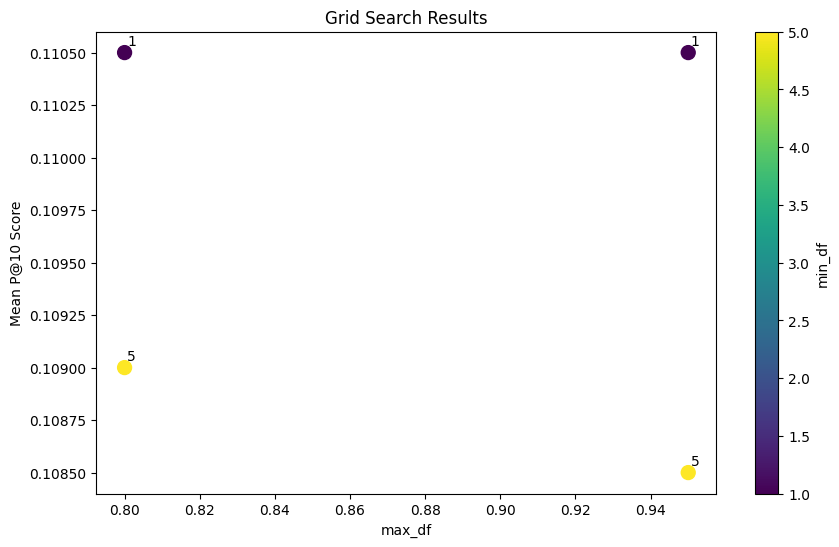

In [36]:
results = pd.DataFrame(grid_search.cv_results_)

plt.figure(figsize=(10, 6))

plt.scatter(
    results['param_vect__max_df'],
    results['mean_test_score'],
    c=results['param_vect__min_df'],
    cmap='viridis',
    s=100
)

plt.colorbar(label='min_df')
plt.xlabel('max_df')
plt.ylabel('Mean P@10 Score')
plt.title('Grid Search Results')

for i, txt in enumerate(results['param_vect__min_df']):
    plt.annotate(
        txt,
        (results['param_vect__max_df'][i], results['mean_test_score'][i]),
        textcoords="offset points",
        xytext=(5,5),  # offsets for better readability
        ha='center'
    )

plt.show()

Improvement Ideas:
1. Implement custom stopword removal using a simple list instead of library
2. Combine title and body scores with weighted averaging
3. Extract multi-word terms from document frequency analysis
4. Use character n-grams for robustness to misspellings
5. Optimize BM25 implementation with sparse matrix operations